In [3]:
import torch
import pandas as pd
import math
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [4]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),                  
            nn.Flatten(2))

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embeddings + x 
        x = self.dropout(x)
        return x
    
model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)

torch.Size([512, 50, 16])


In [6]:
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) # w1 and b1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) # w2 and b2

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

In [7]:
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Embedding vector size
        self.h = h # Number of heads
        # Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        # Just apply the formula from the paper
        # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            # Write a very low value (indicating -inf) to the positions where mask == 0
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1) # (batch, h, seq_len, seq_len) # Apply softmax
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)
        # return attention scores which can be used for visualization
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        # Calculate attention
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)
        
        # Combine all the heads together
        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # Multiply by Wo
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)  
        return self.w_o(x)

In [8]:
class LayerNormalization(nn.Module):

    def __init__(self, features: int, eps:float=10**-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(features)) # alpha is a learnable parameter
        self.bias = nn.Parameter(torch.zeros(features)) # bias is a learnable parameter

    def forward(self, x):
        # x: (batch, seq_len, hidden_size)
         # Keep the dimension for broadcasting
        mean = x.mean(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # Keep the dimension for broadcasting
        std = x.std(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # eps is to prevent dividing by zero or when std is very small
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

In [9]:
class ResidualConnection(nn.Module):
    
        def __init__(self, features: int, dropout: float) -> None:
            super().__init__()
            self.dropout = nn.Dropout(dropout)
            self.norm = LayerNormalization(features)
    
        def forward(self, x, sublayer):
            return x + self.dropout(sublayer(self.norm(x)))

In [10]:
class EncoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

In [11]:
class Encoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [12]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout, activation, num_layers, d_ff):
        super().__init__()
        
        # Multi-head attention block
        self_attention_block = MultiHeadAttentionBlock(
            d_model=embed_dim, 
            h=num_heads, 
            dropout=dropout
        )
        
        # Feedforward block
        feed_forward_block = FeedForwardBlock(
            d_model=embed_dim, 
            d_ff=d_ff, 
            dropout=dropout
        )
        
        # Stack of encoder layers
        layers = nn.ModuleList([
            EncoderBlock(
                features=embed_dim,
                self_attention_block=self_attention_block,
                feed_forward_block=feed_forward_block,
                dropout=dropout
            ) for _ in range(num_layers)
        ])
        
        # Encoder, which contains all the layers
        self.encoder = Encoder(
            features=embed_dim,
            layers=layers
        )

    def forward(self, x):
        # Pass through the encoder (no mask provided)
        return self.encoder(x, mask=None)


In [13]:
class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)
        
         
        self.encoder_blocks = TransformerEncoder(embed_dim,num_heads,dropout,activation,num_encoders, d_ff=hidden_dim)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])  # Apply MLP on the CLS token only
        return x

model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape) # BATCH_SIZE X NUM_CLASSES

torch.Size([512, 10])


In [14]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [15]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [18]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)
        
        return {"image": image, "label": label, "index": index}
    
class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)
        
        return {"image": image, "label": label, "index": index}
    
class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indicies):
        self.images = images
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        index = self.indicies[idx]
        image = self.transform(image)
        
        return {"image": image, "index": index}

37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

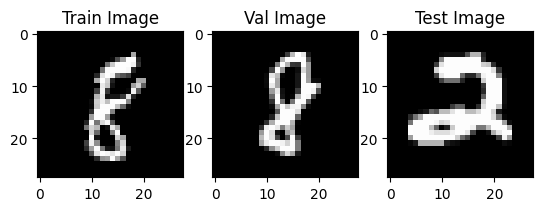

In [19]:
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("Val Image")
print("-"*30)

test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap="gray")
axarr[2].set_title("Test Image")
print("-"*30)

plt.show()

In [20]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

# Before Training

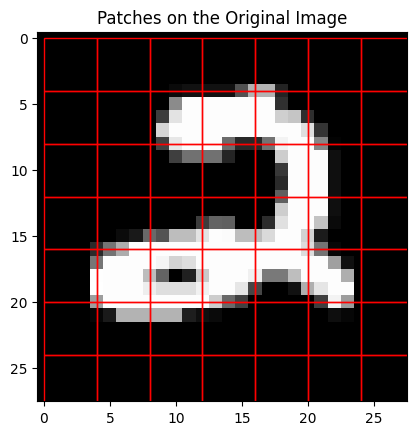

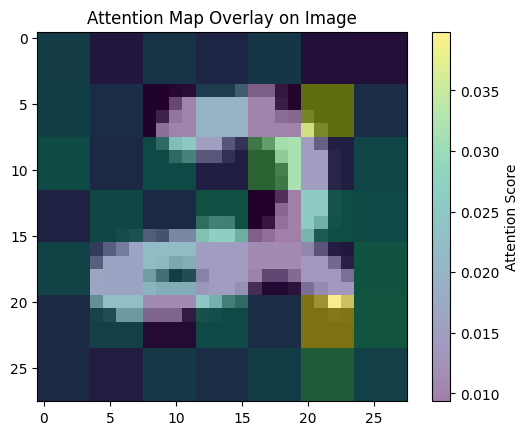

In [21]:
from matplotlib.patches import Rectangle

# Function to visualize patches
def plot_patches_on_image(img, patch_size=4):
    img = img.squeeze()  # Assuming the image has shape (28, 28) or (1, 28, 28)
    fig, ax = plt.subplots(1)
    ax.imshow(img, cmap="gray")
    
    # Draw the patches on the image as a grid of squares
    num_patches = img.shape[0] // patch_size  # Assuming img is square
    for i in range(num_patches):
        for j in range(num_patches):
            rect = Rectangle((j * patch_size, i * patch_size), patch_size, patch_size, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    plt.title('Patches on the Original Image')
    plt.show()

# Function to overlay attention map on the original image
def overlay_attention_on_image(img, attention_map, patch_size=4):
    img = img.squeeze()  # Assuming the image has shape (28, 28)
    num_patches = img.shape[0] // patch_size  # Assuming img is square
    
    # Resize attention map to match image size
    attention_map_resized = attention_map.reshape(num_patches, num_patches)
    
    # Scale attention map to image size by repeating each patch over patch_size pixels
    attention_map_full = np.kron(attention_map_resized, np.ones((patch_size, patch_size)))
    
    # Plot original image with attention overlay
    plt.imshow(img, cmap="gray")
    plt.imshow(attention_map_full, cmap="viridis", alpha=0.5)  # Use alpha to blend attention map
    plt.title('Attention Map Overlay on Image')
    plt.colorbar(label='Attention Score')
    plt.show()

# Get an example image from the test set (for example, first batch from test_dataloader)
for batch in test_dataloader:
    img = batch["image"][0]  # Take the first image from the batch
    img = img.cpu().detach().numpy()  # Convert to numpy
    break

# Visualize the patches on the image
plot_patches_on_image(img, patch_size=PATCH_SIZE)

# Get attention scores (assuming transformer_encoder and data is already prepared)
# Perform a forward pass and get attention scores
model.eval()
with torch.no_grad():
    img_tensor = batch["image"].to(device)  # Send to device
    outputs =  model(img_tensor)
    
    # Extract attention scores from the first encoder block's multi-head attention block
    attention_scores =  model.encoder_blocks.encoder.layers[0].self_attention_block.attention_scores  # From the first encoder layer

# Select an example image and attention head (let's use the first image and first head for now)
example_index = 0
head_index = 0

# Attention scores for that image
attention_map = attention_scores[example_index, head_index, 0, 1:].cpu().detach().numpy()

# Visualize the attention map over the image
overlay_attention_on_image(img, attention_map, patch_size=PATCH_SIZE)


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        loss = criterion(y_pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)         
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

100%|██████████| 9/9 [00:00<00:00, 22.45it/s]


------------------------------
Train Loss EPOCH 1: 2.3083
Valid Loss EPOCH 1: 2.2826
Train Accuracy EPOCH 1: 0.1282


  2%|▎         | 1/40 [00:10<06:52, 10.57s/it]

Valid Accuracy EPOCH 1: 0.1755
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.78it/s]


------------------------------
Train Loss EPOCH 2: 2.2183
Valid Loss EPOCH 2: 2.1130


  5%|▌         | 2/40 [00:21<06:39, 10.52s/it]

Train Accuracy EPOCH 2: 0.1840
Valid Accuracy EPOCH 2: 0.2371
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.90it/s]


------------------------------
Train Loss EPOCH 3: 1.9857
Valid Loss EPOCH 3: 1.8216


  8%|▊         | 3/40 [00:31<06:27, 10.46s/it]

Train Accuracy EPOCH 3: 0.3280
Valid Accuracy EPOCH 3: 0.4460
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.86it/s]


------------------------------
Train Loss EPOCH 4: 1.7492
Valid Loss EPOCH 4: 1.6052
Train Accuracy EPOCH 4: 0.4506


 10%|█         | 4/40 [00:41<06:12, 10.36s/it]

Valid Accuracy EPOCH 4: 0.5245
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.72it/s]


------------------------------
Train Loss EPOCH 5: 1.6033
Valid Loss EPOCH 5: 1.5119
Train Accuracy EPOCH 5: 0.5118


 12%|█▎        | 5/40 [00:52<06:03, 10.38s/it]

Valid Accuracy EPOCH 5: 0.5452
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.59it/s]


------------------------------
Train Loss EPOCH 6: 1.5259
Valid Loss EPOCH 6: 1.4274
Train Accuracy EPOCH 6: 0.5384


 15%|█▌        | 6/40 [01:02<05:54, 10.42s/it]

Valid Accuracy EPOCH 6: 0.5950
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.58it/s]


------------------------------
Train Loss EPOCH 7: 1.4410
Valid Loss EPOCH 7: 1.3447


 18%|█▊        | 7/40 [01:13<05:44, 10.44s/it]

Train Accuracy EPOCH 7: 0.5719
Valid Accuracy EPOCH 7: 0.6133
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.25it/s]


------------------------------
Train Loss EPOCH 8: 1.3738
Valid Loss EPOCH 8: 1.2824


 20%|██        | 8/40 [01:23<05:34, 10.46s/it]

Train Accuracy EPOCH 8: 0.5918
Valid Accuracy EPOCH 8: 0.6352
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.51it/s]


------------------------------
Train Loss EPOCH 9: 1.3191
Valid Loss EPOCH 9: 1.2052


 22%|██▎       | 9/40 [01:33<05:22, 10.40s/it]

Train Accuracy EPOCH 9: 0.6101
Valid Accuracy EPOCH 9: 0.6648
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.58it/s]


------------------------------
Train Loss EPOCH 10: 1.2597
Valid Loss EPOCH 10: 1.1676
Train Accuracy EPOCH 10: 0.6311


 25%|██▌       | 10/40 [01:44<05:12, 10.40s/it]

Valid Accuracy EPOCH 10: 0.6724
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.33it/s]


------------------------------
Train Loss EPOCH 11: 1.2039
Valid Loss EPOCH 11: 1.1037


 28%|██▊       | 11/40 [01:54<05:01, 10.41s/it]

Train Accuracy EPOCH 11: 0.6478
Valid Accuracy EPOCH 11: 0.7019
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.57it/s]


------------------------------
Train Loss EPOCH 12: 1.1544
Valid Loss EPOCH 12: 1.0473


 30%|███       | 12/40 [02:05<04:52, 10.44s/it]

Train Accuracy EPOCH 12: 0.6641
Valid Accuracy EPOCH 12: 0.7202
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.58it/s]


------------------------------
Train Loss EPOCH 13: 1.0992
Valid Loss EPOCH 13: 1.0094


 32%|███▎      | 13/40 [02:15<04:41, 10.43s/it]

Train Accuracy EPOCH 13: 0.6862
Valid Accuracy EPOCH 13: 0.7262
------------------------------


100%|██████████| 9/9 [00:00<00:00, 15.94it/s]


------------------------------
Train Loss EPOCH 14: 1.0435
Valid Loss EPOCH 14: 0.9492
Train Accuracy EPOCH 14: 0.7068


 35%|███▌      | 14/40 [02:26<04:31, 10.43s/it]

Valid Accuracy EPOCH 14: 0.7388
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.37it/s]


------------------------------
Train Loss EPOCH 15: 0.9964
Valid Loss EPOCH 15: 0.9062


 38%|███▊      | 15/40 [02:36<04:19, 10.39s/it]

Train Accuracy EPOCH 15: 0.7194
Valid Accuracy EPOCH 15: 0.7524
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.55it/s]


------------------------------
Train Loss EPOCH 16: 0.9599
Valid Loss EPOCH 16: 0.8791
Train Accuracy EPOCH 16: 0.7305


 40%|████      | 16/40 [02:46<04:09, 10.40s/it]

Valid Accuracy EPOCH 16: 0.7795
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.48it/s]


------------------------------
Train Loss EPOCH 17: 0.9207
Valid Loss EPOCH 17: 0.8261


 42%|████▎     | 17/40 [02:57<03:59, 10.41s/it]

Train Accuracy EPOCH 17: 0.7420
Valid Accuracy EPOCH 17: 0.7762
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.55it/s]


------------------------------
Train Loss EPOCH 18: 0.8799
Valid Loss EPOCH 18: 0.7883
Train Accuracy EPOCH 18: 0.7514


 45%|████▌     | 18/40 [03:07<03:48, 10.40s/it]

Valid Accuracy EPOCH 18: 0.7976
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.50it/s]


------------------------------
Train Loss EPOCH 19: 0.8420
Valid Loss EPOCH 19: 0.7429


 48%|████▊     | 19/40 [03:18<03:39, 10.44s/it]

Train Accuracy EPOCH 19: 0.7624
Valid Accuracy EPOCH 19: 0.8002
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.31it/s]


------------------------------
Train Loss EPOCH 20: 0.8269
Valid Loss EPOCH 20: 0.7182


 50%|█████     | 20/40 [03:28<03:28, 10.42s/it]

Train Accuracy EPOCH 20: 0.7661
Valid Accuracy EPOCH 20: 0.8083
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.66it/s]


------------------------------
Train Loss EPOCH 21: 0.7859
Valid Loss EPOCH 21: 0.6978


 52%|█████▎    | 21/40 [03:38<03:18, 10.45s/it]

Train Accuracy EPOCH 21: 0.7806
Valid Accuracy EPOCH 21: 0.8186
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.22it/s]


------------------------------
Train Loss EPOCH 22: 0.7678
Valid Loss EPOCH 22: 0.6592


 55%|█████▌    | 22/40 [03:49<03:08, 10.49s/it]

Train Accuracy EPOCH 22: 0.7816
Valid Accuracy EPOCH 22: 0.8240
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.54it/s]


------------------------------
Train Loss EPOCH 23: 0.7390
Valid Loss EPOCH 23: 0.6579


 57%|█████▊    | 23/40 [04:00<02:58, 10.50s/it]

Train Accuracy EPOCH 23: 0.7910
Valid Accuracy EPOCH 23: 0.8269
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.61it/s]


------------------------------
Train Loss EPOCH 24: 0.7224
Valid Loss EPOCH 24: 0.6140
Train Accuracy EPOCH 24: 0.7928


 60%|██████    | 24/40 [04:10<02:47, 10.44s/it]

Valid Accuracy EPOCH 24: 0.8302
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.68it/s]


------------------------------
Train Loss EPOCH 25: 0.6919
Valid Loss EPOCH 25: 0.6211
Train Accuracy EPOCH 25: 0.8011


 62%|██████▎   | 25/40 [04:20<02:36, 10.44s/it]

Valid Accuracy EPOCH 25: 0.8236
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.53it/s]


------------------------------
Train Loss EPOCH 26: 0.6830
Valid Loss EPOCH 26: 0.5777


 65%|██████▌   | 26/40 [04:31<02:26, 10.49s/it]

Train Accuracy EPOCH 26: 0.8046
Valid Accuracy EPOCH 26: 0.8483
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.45it/s]


------------------------------
Train Loss EPOCH 27: 0.6617
Valid Loss EPOCH 27: 0.6067


 68%|██████▊   | 27/40 [04:41<02:16, 10.51s/it]

Train Accuracy EPOCH 27: 0.8084
Valid Accuracy EPOCH 27: 0.8243
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.66it/s]


------------------------------
Train Loss EPOCH 28: 0.6475
Valid Loss EPOCH 28: 0.5816


 70%|███████   | 28/40 [04:52<02:06, 10.51s/it]

Train Accuracy EPOCH 28: 0.8113
Valid Accuracy EPOCH 28: 0.8410
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.27it/s]


------------------------------
Train Loss EPOCH 29: 0.6312
Valid Loss EPOCH 29: 0.5465


 72%|███████▎  | 29/40 [05:02<01:55, 10.51s/it]

Train Accuracy EPOCH 29: 0.8168
Valid Accuracy EPOCH 29: 0.8421
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.76it/s]


------------------------------
Train Loss EPOCH 30: 0.6169
Valid Loss EPOCH 30: 0.5297
Train Accuracy EPOCH 30: 0.8187


 75%|███████▌  | 30/40 [05:13<01:44, 10.47s/it]

Valid Accuracy EPOCH 30: 0.8505
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.65it/s]


------------------------------
Train Loss EPOCH 31: 0.5999
Valid Loss EPOCH 31: 0.5389


 78%|███████▊  | 31/40 [05:23<01:34, 10.46s/it]

Train Accuracy EPOCH 31: 0.8235
Valid Accuracy EPOCH 31: 0.8538
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.57it/s]


------------------------------
Train Loss EPOCH 32: 0.5893
Valid Loss EPOCH 32: 0.5203
Train Accuracy EPOCH 32: 0.8279


 80%|████████  | 32/40 [05:34<01:23, 10.46s/it]

Valid Accuracy EPOCH 32: 0.8526
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.54it/s]


------------------------------
Train Loss EPOCH 33: 0.5799
Valid Loss EPOCH 33: 0.5058
Train Accuracy EPOCH 33: 0.8273


 82%|████████▎ | 33/40 [05:44<01:13, 10.49s/it]

Valid Accuracy EPOCH 33: 0.8602
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.31it/s]


------------------------------
Train Loss EPOCH 34: 0.5652
Valid Loss EPOCH 34: 0.5001


 85%|████████▌ | 34/40 [05:55<01:02, 10.46s/it]

Train Accuracy EPOCH 34: 0.8327
Valid Accuracy EPOCH 34: 0.8617
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.49it/s]


------------------------------
Train Loss EPOCH 35: 0.5619
Valid Loss EPOCH 35: 0.4966
Train Accuracy EPOCH 35: 0.8336


 88%|████████▊ | 35/40 [06:05<00:52, 10.46s/it]

Valid Accuracy EPOCH 35: 0.8652
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.51it/s]


------------------------------
Train Loss EPOCH 36: 0.5487
Valid Loss EPOCH 36: 0.4616


 90%|█████████ | 36/40 [06:15<00:41, 10.41s/it]

Train Accuracy EPOCH 36: 0.8358
Valid Accuracy EPOCH 36: 0.8669
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.48it/s]


------------------------------
Train Loss EPOCH 37: 0.5353
Valid Loss EPOCH 37: 0.4494
Train Accuracy EPOCH 37: 0.8400


 92%|█████████▎| 37/40 [06:26<00:31, 10.41s/it]

Valid Accuracy EPOCH 37: 0.8700
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.52it/s]


------------------------------
Train Loss EPOCH 38: 0.5274
Valid Loss EPOCH 38: 0.4573


 95%|█████████▌| 38/40 [06:36<00:20, 10.43s/it]

Train Accuracy EPOCH 38: 0.8416
Valid Accuracy EPOCH 38: 0.8750
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.58it/s]


------------------------------
Train Loss EPOCH 39: 0.5193
Valid Loss EPOCH 39: 0.4381
Train Accuracy EPOCH 39: 0.8443


 98%|█████████▊| 39/40 [06:47<00:10, 10.43s/it]

Valid Accuracy EPOCH 39: 0.8740
------------------------------


100%|██████████| 9/9 [00:00<00:00, 22.64it/s]


------------------------------
Train Loss EPOCH 40: 0.5032
Valid Loss EPOCH 40: 0.4332
Train Accuracy EPOCH 40: 0.8496


100%|██████████| 40/40 [06:57<00:00, 10.44s/it]

Valid Accuracy EPOCH 40: 0.8764
------------------------------
Training Time: 417.72s


In [23]:
torch.cuda.empty_cache()

In [24]:
labels = []
ids = []
imgs = []
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i)+1 for i in sample["index"]])
        
        outputs = model(img)
        
        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

100%|██████████| 55/55 [00:02<00:00, 19.05it/s]


<Figure size 640x480 with 0 Axes>

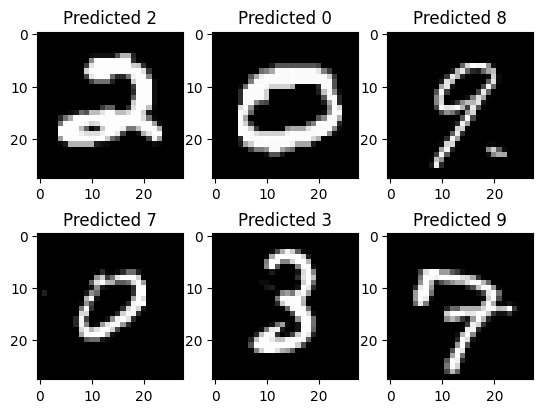

In [25]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1

In [26]:
for batch in test_dataloader:
    img = batch["image"].to(device)  # Move images to the device
    break  # Let's just take the first batch for simplicity

# Get model outputs
outputs =  model(img)

# Access the attention scores from the MultiHeadAttentionBlock (assuming the model is initialized as transformer_encoder)
attention_scores =  model.encoder_blocks.encoder.layers[0].self_attention_block.attention_scores  # From the first encoder layer

print(attention_scores.shape)  # Should be (batch_size, num_heads, seq_len, seq_len)


torch.Size([512, 8, 50, 50])


In [27]:
img.shape

torch.Size([512, 1, 28, 28])

# After Traning

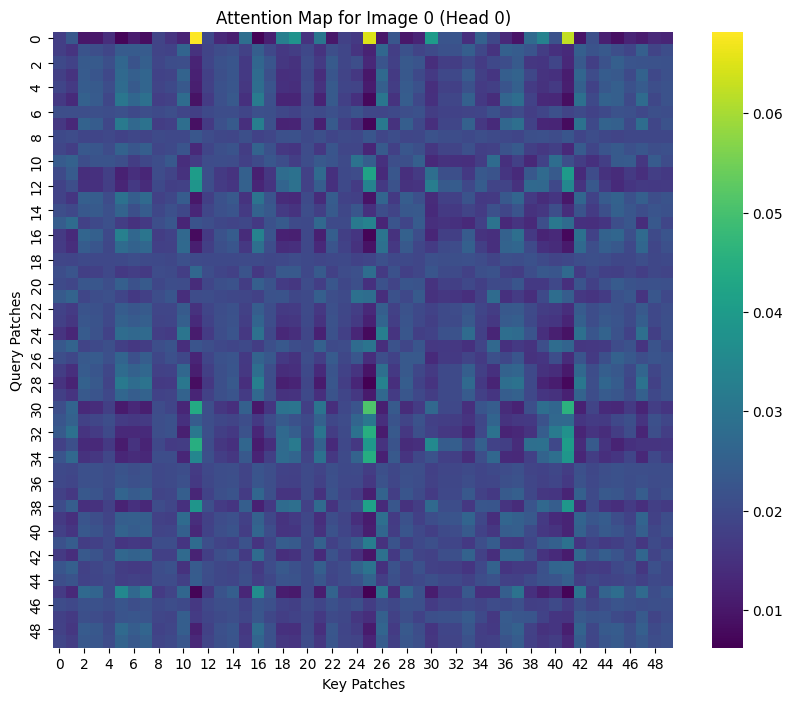

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Choose an example image from the batch (e.g., the first image)
example_index = 0

# Choose a specific attention head to visualize
head_index = 0

# Get the attention map for the chosen example and attention head
attention_map = attention_scores[example_index, head_index, :, :].detach().cpu().numpy()

# Plot the attention map using Seaborn or Matplotlib
plt.figure(figsize=(10, 8))
sns.heatmap(attention_map, cmap="viridis")
plt.title(f"Attention Map for Image {example_index} (Head {head_index})")
plt.xlabel("Key Patches")
plt.ylabel("Query Patches")
plt.show()


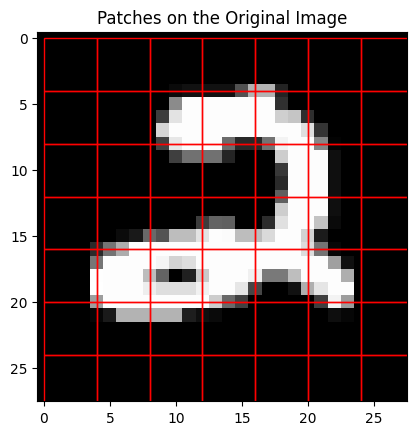

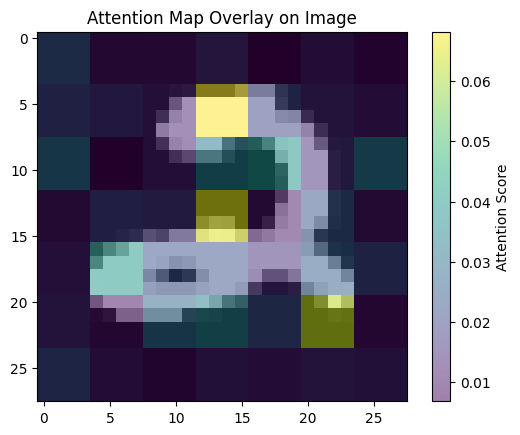

In [29]:
from matplotlib.patches import Rectangle

# Function to visualize patches
def plot_patches_on_image(img, patch_size=4):
    img = img.squeeze()  # Assuming the image has shape (28, 28) or (1, 28, 28)
    fig, ax = plt.subplots(1)
    ax.imshow(img, cmap="gray")
    
    # Draw the patches on the image as a grid of squares
    num_patches = img.shape[0] // patch_size  # Assuming img is square
    for i in range(num_patches):
        for j in range(num_patches):
            rect = Rectangle((j * patch_size, i * patch_size), patch_size, patch_size, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    plt.title('Patches on the Original Image')
    plt.show()

# Function to overlay attention map on the original image
def overlay_attention_on_image(img, attention_map, patch_size=4):
    img = img.squeeze()  # Assuming the image has shape (28, 28)
    num_patches = img.shape[0] // patch_size  # Assuming img is square
    
    # Resize attention map to match image size
    attention_map_resized = attention_map.reshape(num_patches, num_patches)
    
    # Scale attention map to image size by repeating each patch over patch_size pixels
    attention_map_full = np.kron(attention_map_resized, np.ones((patch_size, patch_size)))
    
    # Plot original image with attention overlay
    plt.imshow(img, cmap="gray")
    plt.imshow(attention_map_full, cmap="viridis", alpha=0.5)  # Use alpha to blend attention map
    plt.title('Attention Map Overlay on Image')
    plt.colorbar(label='Attention Score')
    plt.show()

# Get an example image from the test set (for example, first batch from test_dataloader)
for batch in test_dataloader:
    img = batch["image"][0]  # Take the first image from the batch
    img = img.cpu().detach().numpy()  # Convert to numpy
    break

# Visualize the patches on the image
plot_patches_on_image(img, patch_size=PATCH_SIZE)

# Get attention scores (assuming transformer_encoder and data is already prepared)
# Perform a forward pass and get attention scores
model.eval()
with torch.no_grad():
    img_tensor = batch["image"].to(device)  # Send to device
    outputs =  model(img_tensor)
    
    # Extract attention scores from the first encoder block's multi-head attention block
    attention_scores =  model.encoder_blocks.encoder.layers[0].self_attention_block.attention_scores  # From the first encoder layer

# Select an example image and attention head (let's use the first image and first head for now)
example_index = 0
head_index = 0

# Attention scores for that image
attention_map = attention_scores[example_index, head_index, 0, 1:].cpu().detach().numpy()

# Visualize the attention map over the image
overlay_attention_on_image(img, attention_map, patch_size=PATCH_SIZE)


In [30]:
import numpy as np

# Define two matrices
A = np.array([[1, 2], 
              [3, 4]])

B = np.array([[0, 5], 
              [6, 7]])

# Compute the Kronecker product of A and B
result = np.kron(A, B)

print(result)


[[ 0  5  0 10]
 [ 6  7 12 14]
 [ 0 15  0 20]
 [18 21 24 28]]
